## Dataset Loader

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from mapillary_vistas_dataset import MapillaryVistasDataset

MAX_IMAGES = 2000
IMAGE_DIMEN = 256
BATCH_SIZE = 16

IMAGE_TRANSFORM = transforms.Compose([
    transforms.CenterCrop(IMAGE_DIMEN),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
MAKS_TRANSFORM = transforms.Compose([
    transforms.CenterCrop(IMAGE_DIMEN)
])

TRAINING_DATASET_NAME = f"{MAX_IMAGES}-{IMAGE_DIMEN}-{BATCH_SIZE}-crop"
training_dataset = MapillaryVistasDataset(MapillaryVistasDataset.TRAINING,
                                          max_images=MAX_IMAGES,
                                          transform=IMAGE_TRANSFORM,
                                          mask_transform=MAKS_TRANSFORM)
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)


## Training

In [ ]:
from unet import UNet
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from train import train_model

LEARNING_RATE = 0.001
EPOCHS = 50
CRITERION = F.cross_entropy

LOAD_CHECKPOINT_PATH = None

MODEL_NAME = f"unet-{TRAINING_DATASET_NAME}-{EPOCHS}-{str(LEARNING_RATE).replace('.', '')}"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=3, out_channels=len(MapillaryVistasDataset.color_to_i)).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


LOAD_CHECKPOINT_PATH = None

model_info = train_model(model=model, 
                                 epochs=EPOCHS, 
                                 learning_rate=LEARNING_RATE, 
                                 criterion=CRITERION, 
                                 training_loader=training_loader, 
                                 optimizer=optimizer, 
                                 device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
                                 name=MODEL_NAME, 
                                 checkpoint_path=LOAD_CHECKPOINT_PATH, 
                                 save=True)

## Load Model

In [3]:
from evaluation import evaluate_model
from mapillary_vistas_dataset import MapillaryVistasDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

SAVED_MODEL_NAME = MODEL_NAME #"unet-256-crop-50-2000-001"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if SAVED_MODEL_NAME:
    saved_model_path = f"/virtual/csc490_mapillary/models/{SAVED_MODEL_NAME}/{SAVED_MODEL_NAME}.pth"
    print(f"Evaluating {saved_model_path}...")
    model = UNet(in_channels=3, out_channels=MapillaryVistasDataset.NUM_CLASSES).to(device)
    model_info = torch.load(saved_model_path)
    model.load_state_dict(model_info['state_dict'])
    print(f"Accuracies: {model_info['accuracies']}")
    print(f"Losses: {model_info['losses']}")
else:
    print(f"Evaluating {SAVED_MODEL_NAME}..")

Loading /virtual/csc490_mapillary/models/unet-5000-256-16-crop-50-0001/unet-5000-256-16-crop-50-0001.pth...


## EVALUATION

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import math
from matplotlib.patches import Rectangle

def label_to_rgb(mask_tensor, color_map):
    # Create an empty RGB image

    rgb_image = torch.zeros(3, mask_tensor.shape[-2], mask_tensor.shape[-1], dtype=torch.uint8)

    # Map each label to its RGB color
    for label, color in color_map.items():
        for channel, intensity in enumerate(color):
            rgb_image[channel][mask_tensor == label] = intensity

    return rgb_image

def display_results(input_image_path, ground_truth_image_path, model, color_map, color_label):
    # Load and process the input image

    crop_size = 256
    input_image = Image.open(input_image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
    _, predicted_mask = torch.max(prediction, 1)

    # Convert tensor to color-coded image
    predicted_rgb = label_to_rgb(predicted_mask.squeeze(0).cpu(), color_map)
    predicted_image = transforms.ToPILImage()(predicted_rgb)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image

    transform = transforms.Compose([transforms.CenterCrop(crop_size)])

    axes[0].imshow(transform(input_image))
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Display predicted mask
    axes[1].imshow((predicted_image))
    axes[1].set_title("Model Prediction")
    axes[1].axis("off")

    # Display ground truth, if provided
    if ground_truth_image_path:
        ground_truth = Image.open(ground_truth_image_path)
        axes[2].imshow(transform(ground_truth), cmap="gray")
        axes[2].set_title("Ground Truth")
        axes[2].axis("off")
    else:
        axes[2].remove()
    plt.tight_layout()
    plt.show()


    cell_width = 240
    cell_height = 22
    swatch_width = 48
    margin = 12

    n = len(color_label)
    ncols = 6
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()


    i = 0
    for rgb, name in color_label.items():
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        rgb_float = [x/255 for x in rgb]


        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=rgb_float, edgecolor='0.7')
        )
        i+=1
    plt.show()


### Test

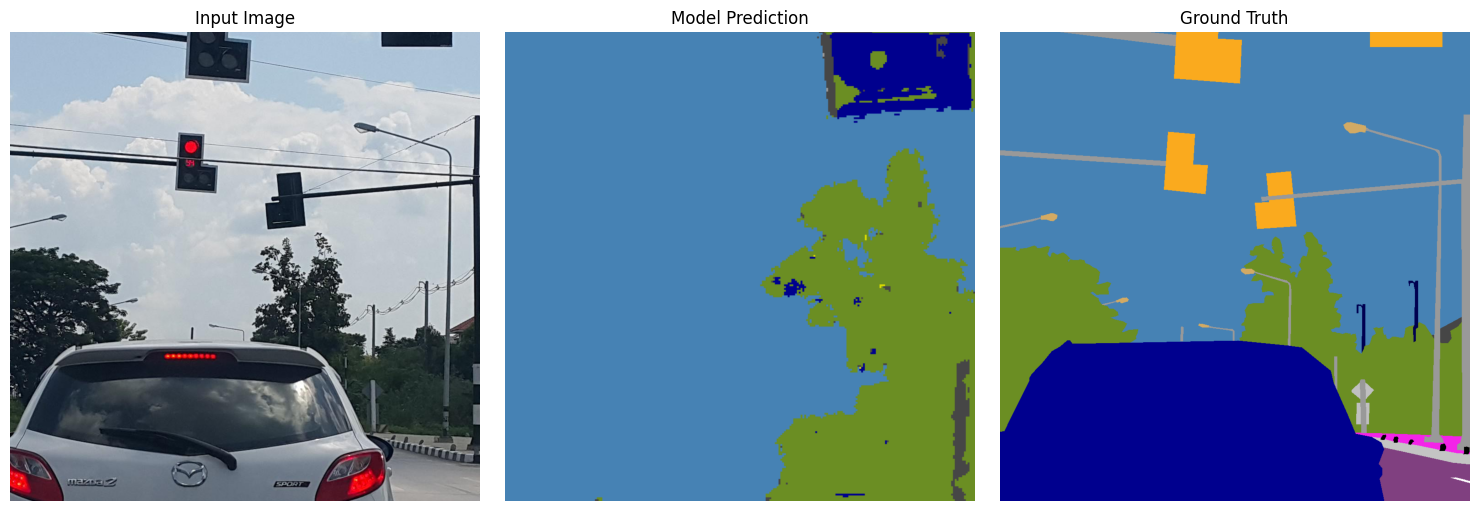

In [ ]:
# Assuming your model is already loaded and on the correct device.
ROOT_DIR = "/virtual/csc490_mapillary/data_v12"
image = "FYoB0UGu40k9nKurB8pucw"
path_input_image = ROOT_DIR + f'/validation/images/{image}.jpg'
path_labeled_image = ROOT_DIR + f'/validation/labels/{image}.png'
display_results(path_input_image, path_labeled_image, model, MapillaryVistasDataset.i_to_color, MapillaryVistasDataset.color_name)